# **Importaci√≥n de bibliotecas**

In [ ]:
"""
Este notebook utiliza diversas librer√≠as que permiten realizar tareas de c√°lculo num√©rico,
procesamiento de datos, an√°lisis de audio, visualizaci√≥n y manipulaci√≥n de im√°genes, adem√°s de
integrarse con Google Drive. A continuaci√≥n se describen brevemente cada uno de los m√≥dulos importados:

- torch: Biblioteca para computaci√≥n num√©rica avanzada y operaciones con tensores, optimizada para GPU.
- numpy: Librer√≠a fundamental para computaci√≥n cient√≠fica en Python, especialmente en operaciones
         con arreglos multidimensionales.
- unittest: M√≥dulo est√°ndar de Python para la creaci√≥n y ejecuci√≥n de pruebas unitarias.
- scipy.io.wavfile: Funciones para leer y escribir archivos de audio en formato WAV.
- matplotlib.pyplot: M√≥dulo para la generaci√≥n de gr√°ficos y visualizaciones de datos.
- google.colab.drive: Permite montar y acceder a Google Drive directamente desde el entorno de Colab.
- PIL.Image: Parte de la librer√≠a Pillow para abrir, manipular y guardar im√°genes.
"""

import torch  # PyTorch: operaciones tensoriales y c√°lculos optimizados para GPU
import numpy as np  # NumPy: soporte para arrays y operaciones matem√°ticas de alto rendimiento
import unittest  # Unittest: framework para realizar pruebas unitarias
from scipy.io import wavfile  # Funciones para manejo de archivos WAV (lectura y escritura de audio)
import matplotlib.pyplot as plt  # Matplotlib: creaci√≥n de gr√°ficos y visualizaciones
from google.colab import drive  # Integraci√≥n con Google Drive para acceder a archivos almacenados en la nube
from PIL import Image  # Pillow: manipulaci√≥n y procesamiento de im√°genes


# **Importaci√≥n de datos**

In [ ]:
drive.mount('/content/drive', force_remount=True)

C4_02_1_1_DAPI_001_bmp = '/content/drive/MyDrive/TP1/input/C4_02_1_1_DAPI_001.bmp'
C4_02_1_1_DAPI_001_tif = '/content/drive/MyDrive/TP1/input/C4_02_1_1_DAPI_001.tif'
contaminated_audio = '/content/drive/MyDrive/TP1/input/contaminated_audio.wav'
cuadro1_005 = '/content/drive/MyDrive/TP1/input/cuadro1_005.bmp'
manu = '/content/drive/MyDrive/TP1/input/manu.jpg'
trackedCell15 = '/content/drive/MyDrive/TP1/input/trackedCell15.tif'

Mounted at /content/drive


In [ ]:
def charge_image(image_url: str) -> torch.Tensor:
    """
    Carga una imagen desde una ruta o URL, la convierte a escala de grises y la transforma en un tensor de PyTorch.

    La funci√≥n realiza los siguientes pasos:
      1. Abre la imagen usando la librer√≠a PIL a partir de la ruta o URL especificada.
      2. Convierte la imagen a escala de grises mediante el m√©todo 'convert("L")'.
      3. Transforma la imagen en un array de NumPy.
      4. Convierte el array de NumPy en un tensor de PyTorch con tipo float32.

    Par√°metros:
    -----------
    image_url : str
        Ruta o URL de la imagen a cargar.

    Retorna:
    --------
    torch.Tensor
        Tensor que representa la imagen en escala de grises.

    Notas:
    ------
    - Se asume que la imagen se encuentra en una ubicaci√≥n accesible y que puede ser abierta con PIL.
    - En caso de error al cargar la imagen, se genera una excepci√≥n con un mensaje descriptivo.
    """
    try:
        # Abrir la imagen utilizando la ruta o URL proporcionada y convertirla a escala de grises.
        imagen_pil = Image.open(image_url).convert("L")
    except Exception as e:
        # En caso de fallo, lanzar una excepci√≥n con informaci√≥n del error.
        raise ValueError(f"No se pudo cargar la imagen desde {image_url}. Error: {e}")

    # Convertir la imagen PIL a un array de NumPy.
    imagen_np = np.array(imagen_pil)

    # Convertir el array de NumPy en un tensor de PyTorch de tipo float32.
    imagen_tensor = torch.tensor(imagen_np, dtype=torch.float32)

    return imagen_tensor

# **Implementaci√≥n del algoritmo de Kittler**

**Algoritmo de Kittler:**

El algoritmo de Kittler, tambi√©n conocido como Minimum Error Thresholding, se utiliza en el procesamiento de im√°genes para segmentar una imagen en dos clases (por ejemplo, fondo y objeto) asumiendo que ambas clases pueden modelarse mediante distribuciones gaussianas.

Prop√≥sito:
Determinar el umbral √≥ptimo que minimice el error de clasificaci√≥n, es decir, que reduzca la probabilidad de mal clasificar los p√≠xeles entre fondo y objeto.

C√≥mo Funciona:

Se calcula el histograma de la imagen y se normaliza para obtener la funci√≥n de densidad de probabilidad (p).

Para cada posible umbral candidato (T), se separa la imagen en dos grupos:

Fondo: p√≠xeles con intensidades ‚â§ T.

Objeto: p√≠xeles con intensidades > T.

Se calculan los momentos estad√≠sticos de cada grupo: probabilidad (œâ), media (Œº) y varianza (œÉ¬≤).

Con estos par√°metros, se eval√∫a una funci√≥n de coste basada en la suposici√≥n de modelos gaussianos para ambos grupos.

El umbral que minimiza este coste se considera el √≥ptimo para la segmentaci√≥n.

Aplicaci√≥n en Procesamiento de Im√°genes:
Este m√©todo se aplica en tareas de segmentaci√≥n donde se requiere separar el fondo del objeto, como en an√°lisis m√©dico, reconocimiento de patrones o en la preparaci√≥n de im√°genes para an√°lisis posteriores.

## 1.
Implemente el algoritmo de Kittler, y realice una prueba con la imagen de entrada provista, aplicando posteriormente el umbral √≥ptimo obtenido.

### **a.**

In [ ]:
def calcular_momentos_estadisticos(T: int, p: torch.Tensor) -> dict:
    """
    Calcula los momentos estad√≠sticos (probabilidad, media y varianza) para dos clases
    separadas por un umbral T en una funci√≥n de densidad de probabilidad.

    La funci√≥n asume que 'p' es un tensor de PyTorch de 1D que contiene la densidad de
    probabilidad normalizada de los niveles de intensidad de una imagen, es decir, cada
    posici√≥n en 'p' representa la probabilidad de ocurrencia de la intensidad correspondiente.

    Se divide la funci√≥n de densidad en dos grupos:
        - Grupo fondo: niveles de intensidad desde 0 hasta T (inclusive).
        - Grupo objeto: niveles de intensidad desde T+1 hasta el final.

    Para cada grupo se calculan:
        - omega: suma de probabilidades (indicador de la masa total del grupo).
        - mu: media ponderada de las intensidades.
        - sigma: varianza ponderada de las intensidades.

    Par√°metros:
    -----------
    T : int
        Valor de umbral candidato que separa los dos grupos. Representa un √≠ndice de intensidad.
    p : torch.Tensor
        Tensor 1D normalizado que contiene la probabilidad de cada nivel de intensidad.

    Retorna:
    --------
    dict
        Diccionario con los siguientes par√°metros:
            - 'omega0': Probabilidad total del grupo fondo (niveles 0 a T).
            - 'omega1': Probabilidad total del grupo objeto (niveles T+1 a L-1).
            - 'mu0': Media del grupo fondo.
            - 'mu1': Media del grupo objeto.
            - 'sigma0': Varianza del grupo fondo.
            - 'sigma1': Varianza del grupo objeto.
    """

    # Crear un vector con los √≠ndices de intensidad (0, 1, ..., L-1)
    niveles = torch.arange(len(p), dtype=torch.float32)

    # --- C√°lculo para el grupo de fondo ---
    # Si T es menor a 0, se asume que no existe grupo de fondo y se asignan ceros.
    if T < 0:
        omega0 = torch.tensor(0.0)
        mu0 = torch.tensor(0.0)
        sigma0 = torch.tensor(0.0)
    else:
        # Seleccionar los valores de la funci√≥n de densidad para intensidades de 0 a T.
        p_fondo = p[:T+1]
        # Seleccionar los niveles de intensidad correspondientes.
        niveles_fondo = niveles[:T+1]
        # Calcular la probabilidad total (masa) del fondo.
        omega0 = torch.sum(p_fondo)
        if omega0 > 0:
            # Calcular la media del fondo: suma de (intensidad * probabilidad) dividida entre la masa.
            mu0 = torch.sum(niveles_fondo * p_fondo) / omega0
            # Calcular la varianza del fondo: suma ponderada de las diferencias al cuadrado respecto a la media.
            sigma0 = torch.sum(p_fondo * (niveles_fondo - mu0)**2) / omega0
        else:
            # En caso de que omega0 sea 0, se asignan ceros a media y varianza.
            mu0 = torch.tensor(0.0)
            sigma0 = torch.tensor(0.0)

    # --- C√°lculo para el grupo de objeto ---
    # Si T es mayor o igual al √∫ltimo √≠ndice, se considera que no hay grupo de objeto.
    if T >= len(p) - 1:
        omega1 = torch.tensor(0.0)
        mu1 = torch.tensor(0.0)
        sigma1 = torch.tensor(0.0)
    else:
        # Seleccionar los valores de la funci√≥n de densidad para intensidades de T+1 al final.
        p_objeto = p[T+1:]
        # Seleccionar los niveles de intensidad correspondientes.
        niveles_objeto = niveles[T+1:]
        # Calcular la probabilidad total (masa) del objeto.
        omega1 = torch.sum(p_objeto)
        if omega1 > 0:
            # Calcular la media del objeto.
            mu1 = torch.sum(niveles_objeto * p_objeto) / omega1
            # Calcular la varianza del objeto.
            sigma1 = torch.sum(p_objeto * (niveles_objeto - mu1)**2) / omega1
        else:
            # En caso de que omega1 sea 0, se asignan ceros a media y varianza.
            mu1 = torch.tensor(0.0)
            sigma1 = torch.tensor(0.0)

    # Convertir los tensores escalares a valores num√©ricos utilizando .item() y retornar en un diccionario.
    return {
        'omega0': omega0.item(),  # Probabilidad total del fondo.
        'omega1': omega1.item(),  # Probabilidad total del objeto.
        'mu0': mu0.item(),        # Media del fondo.
        'mu1': mu1.item(),        # Media del objeto.
        'sigma0': sigma0.item(),  # Varianza del fondo.
        'sigma1': sigma1.item()   # Varianza del objeto.
    }


#### a.1.

In [ ]:
class TestCalcularMomentosEstadisticos(unittest.TestCase):
    def setUp(self):
        """
        M√©todo de configuraci√≥n que se ejecuta antes de cada prueba.
        Se crea un histograma uniforme de 256 niveles, que se normaliza para que la suma sea 1.
        Este histograma se utilizar√° en todas las pruebas para asegurar consistencia.
        """
        self.num_bins = 256
        # Crear un histograma uniforme: cada nivel tiene la misma probabilidad.
        self.p_uniforme = torch.ones(self.num_bins, dtype=torch.float32)
        self.p_uniforme = self.p_uniforme / torch.sum(self.p_uniforme)

    def test_histograma_uniforme(self):
        """
        Prueba con un histograma uniforme:
        - Se utiliza un umbral T = 127, por lo que se espera que:
            ‚Ä¢ El grupo fondo contenga 128 valores (0 a 127) y el objeto los restantes (128 a 255).
            ‚Ä¢ Las probabilidades (omega0 y omega1) sean 0.5 cada una.
            ‚Ä¢ La media y varianza se calculen te√≥ricamente para una distribuci√≥n uniforme en esos rangos.
        """
        T = 127
        resultados = calcular_momentos_estadisticos(T, self.p_uniforme)
        print("resultado test_histograma_uniforme: ", resultados)

        # Probabilidades esperadas: fondo y objeto con 128 valores cada uno.
        omega0_esperado = 128 / 256  # 0.5
        omega1_esperado = 128 / 256  # 0.5

        # Media esperada para el fondo: promedio de 0 a 127.
        mu0_esperado = (0 + 127) / 2  # 63.5
        # Media esperada para el objeto: promedio de 128 a 255.
        mu1_esperado = (128 + 255) / 2  # 191.5

        # Varianza para una distribuci√≥n uniforme discreta:
        # F√≥rmula: ((n^2 - 1) / 12), donde n es el n√∫mero de valores.
        sigma0_esperado = (128**2 - 1) / 12  # Aproximadamente 1365.25
        sigma1_esperado = sigma0_esperado       # Misma varianza para ambos grupos uniformes

        # Comprobaci√≥n de las probabilidades (omega)
        self.assertAlmostEqual(resultados['omega0'], omega0_esperado, places=3)
        self.assertAlmostEqual(resultados['omega1'], omega1_esperado, places=3)
        # Comprobaci√≥n de las medias (mu)
        self.assertAlmostEqual(resultados['mu0'], mu0_esperado, places=3)
        self.assertAlmostEqual(resultados['mu1'], mu1_esperado, places=3)
        # Comprobaci√≥n de las varianzas (sigma)
        self.assertAlmostEqual(resultados['sigma0'], sigma0_esperado, places=3)
        self.assertAlmostEqual(resultados['sigma1'], sigma1_esperado, places=3)

    def test_todo_en_fondo(self):
        """
        Prueba donde el umbral T es igual al m√°ximo √≠ndice (T = 255):
        - Se espera que todo el histograma se considere fondo.
        - La probabilidad del fondo (omega0) debe ser 1, y la del objeto (omega1) 0.
        - La media y varianza se calculan sobre el rango completo [0, 255].
        """
        T = 255  # Todo se considera fondo
        resultados = calcular_momentos_estadisticos(T, self.p_uniforme)
        print("resultado test_todo_en_fondo: ", resultados)

        # Probabilidades esperadas
        omega0_esperado = 1.0
        omega1_esperado = 0.0

        # C√°lculo te√≥rico para una distribuci√≥n uniforme en [0, 255]
        mu0_esperado = (0 + 255) / 2  # 127.5
        sigma0_esperado = ((256**2 - 1) / 12)  # Aproximadamente 5461.25

        self.assertAlmostEqual(resultados['omega0'], omega0_esperado, places=3)
        self.assertAlmostEqual(resultados['omega1'], omega1_esperado, places=3)
        self.assertAlmostEqual(resultados['mu0'], mu0_esperado, places=3)
        self.assertAlmostEqual(resultados['sigma0'], sigma0_esperado, places=3)
        # Para el grupo objeto se esperan ceros
        self.assertAlmostEqual(resultados['mu1'], 0.0, places=3)
        self.assertAlmostEqual(resultados['sigma1'], 0.0, places=3)

    def test_todo_en_objeto(self):
        """
        Prueba donde el umbral T es menor que el m√≠nimo (T = -1):
        - Se espera que no haya fondo, es decir, que todo el histograma se considere objeto.
        - La probabilidad del fondo (omega0) debe ser 0, y la del objeto (omega1) 1.
        - La media y varianza se calculan sobre el rango completo [0, 255] para el objeto.
        """
        T = -1  # No hay fondo, todo se considera objeto
        resultados = calcular_momentos_estadisticos(T, self.p_uniforme)
        print("resultado test_todo_en_objeto: ", resultados)

        # Probabilidades esperadas
        omega0_esperado = 0.0
        omega1_esperado = 1.0

        # C√°lculo te√≥rico para una distribuci√≥n uniforme en [0, 255] para el grupo objeto.
        mu1_esperado = (0 + 255) / 2  # 127.5
        sigma1_esperado = ((256**2 - 1) / 12)  # Aproximadamente 5461.25

        self.assertAlmostEqual(resultados['omega0'], omega0_esperado, places=3)
        self.assertAlmostEqual(resultados['omega1'], omega1_esperado, places=3)
        # Para el fondo se esperan ceros
        self.assertAlmostEqual(resultados['mu0'], 0.0, places=3)
        self.assertAlmostEqual(resultados['sigma0'], 0.0, places=3)
        # Comprobaci√≥n para el grupo objeto
        self.assertAlmostEqual(resultados['mu1'], mu1_esperado, places=3)
        self.assertAlmostEqual(resultados['sigma1'], sigma1_esperado, places=3)


# Ejecutar las pruebas unitarias
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


......
----------------------------------------------------------------------
Ran 6 tests in 0.012s

OK


Costo para histograma delta y T=50: -26.631023115927547
Costo para histograma delta y T=150: -26.631023115927547
Costo para histograma uniforme y T=255: 18.210863960898507
Costo para histograma uniforme y T=127: 16.824476044653352
resultado test_histograma_uniforme:  {'omega0': 0.5, 'omega1': 0.5, 'mu0': 63.5, 'mu1': 191.5, 'sigma0': 1365.25, 'sigma1': 1365.25}
resultado test_todo_en_fondo:  {'omega0': 1.0, 'omega1': 0.0, 'mu0': 127.5, 'mu1': 0.0, 'sigma0': 5461.25, 'sigma1': 0.0}
resultado test_todo_en_objeto:  {'omega0': 0.0, 'omega1': 1.0, 'mu0': 0.0, 'mu1': 127.5, 'sigma0': 0.0, 'sigma1': 5461.25}


In [ ]:
def calcular_histograma_normalizado(imagen: torch.Tensor, num_bins: int = 256) -> tuple:
    """
    Calcula el histograma normalizado de una imagen en escala de grises.

    La funci√≥n asume que la imagen ya est√° cargada como un tensor de PyTorch en escala de grises.
    Realiza los siguientes pasos:
      1. Aplana el tensor de la imagen para obtener un vector unidimensional de p√≠xeles.
      2. Convierte el vector de p√≠xeles a un array de NumPy para utilizar la funci√≥n np.histogram.
      3. Calcula el histograma de la imagen, utilizando el n√∫mero de bins especificado y el rango [0, num_bins].
      4. Convierte el histograma resultante a un tensor de PyTorch (tipo float32).
      5. Normaliza el histograma dividiendo cada valor por la suma total de los elementos, de modo que la suma de las frecuencias sea 1.

    Par√°metros:
    -----------
    imagen : torch.Tensor
        Tensor que representa la imagen en escala de grises. Se espera que las intensidades est√©n en el rango [0, 255].
    num_bins : int, opcional
        N√∫mero de bins (niveles de intensidad) para calcular el histograma. Por defecto es 256, lo que es
        adecuado para im√°genes con intensidades en el rango [0, 255].

    Retorna:
    --------
    tuple
        Una tupla que contiene:
          - hist_normalizado (torch.Tensor): Tensor 1D con el histograma normalizado, donde cada elemento
            representa la frecuencia relativa de p√≠xeles en el rango correspondiente.
          - bin_edges (np.ndarray): Array de NumPy con los bordes de los bins utilizados en el histograma.
    """
    # Aplanar la imagen para obtener un vector unidimensional con todos los p√≠xeles.
    pixels = imagen.flatten()

    # Convertir el tensor de p√≠xeles a un array de NumPy para utilizar la funci√≥n np.histogram.
    pixels_np = pixels.numpy()

    # Calcular el histograma de la imagen.
    # Se especifica el n√∫mero de bins y el rango de intensidades (0 a num_bins).
    hist, bin_edges = np.histogram(pixels_np, bins=num_bins, range=(0, num_bins))

    # Convertir el histograma a un tensor de PyTorch con tipo float32.
    hist_tensor = torch.tensor(hist, dtype=torch.float32)

    # Normalizar el histograma para que la suma de sus elementos sea 1.
    hist_normalizado = hist_tensor / torch.sum(hist_tensor)

    return hist_normalizado, bin_edges


### b.

In [ ]:
def calcular_costo_J(T: int, p: torch.Tensor) -> float:
    """
    Calcula el costo J para un umbral candidato T usando la formulaci√≥n del algoritmo de Kittler.

    El costo se define mediante la siguiente expresi√≥n:

        J(T) = 1 + 2*(œâ‚ÇÄ * log(œÉ‚ÇÄ + Œµ) + œâ‚ÇÅ * log(œÉ‚ÇÅ + Œµ)) - 2*(œâ‚ÇÄ * log(œâ‚ÇÄ + Œµ) + œâ‚ÇÅ * log(œâ‚ÇÅ + Œµ))

    donde:
      - œâ‚ÇÄ y œâ‚ÇÅ son las probabilidades (pesos) de las clases de fondo y objeto, respectivamente.
      - œÉ‚ÇÄ y œÉ‚ÇÅ son las varianzas de cada clase.
      - Œµ es un valor peque√±o para evitar problemas al calcular el logaritmo de cero.

    Estos par√°metros se obtienen a partir de la funci√≥n de densidad de probabilidad `p` y del umbral `T`,
    mediante la funci√≥n `calcular_momentos_estadisticos`.

    Par√°metros:
    -----------
    T : int
        Umbral candidato para segmentar la imagen.
    p : torch.Tensor
        Tensor 1D que representa el histograma normalizado (funci√≥n de densidad) de los niveles de intensidad.

    Retorna:
    --------
    float
        Valor del costo J para el umbral T.
    """
    # Obtener los momentos estad√≠sticos para el umbral T mediante la funci√≥n auxiliar.
    # Se espera que 'momentos' sea un diccionario con las claves:
    #   'omega0', 'omega1', 'sigma0' y 'sigma1'
    momentos = calcular_momentos_estadisticos(T, p)
    omega0 = momentos['omega0']  # Probabilidad total del grupo fondo.
    omega1 = momentos['omega1']  # Probabilidad total del grupo objeto.
    sigma0 = momentos['sigma0']  # Varianza del grupo fondo.
    sigma1 = momentos['sigma1']  # Varianza del grupo objeto.

    # Definir un peque√±o epsilon para evitar el c√°lculo de log(0), lo cual producir√≠a errores.
    epsilon = 1e-6

    # C√°lculo del costo J(T):
    # Se compone de tres t√©rminos:
    # 1. T√©rmino constante: 1.
    # 2. T√©rmino de dispersi√≥n: penaliza varianzas (œÉ‚ÇÄ y œÉ‚ÇÅ) de cada grupo.
    # 3. T√©rmino de entrop√≠a: incorpora logaritmos de las probabilidades (œâ‚ÇÄ y œâ‚ÇÅ).
    #
    # Se utiliza np.log() de NumPy, ya que los valores son de tipo float.
    costo = (1 +
             2 * (omega0 * np.log(sigma0 + epsilon) + omega1 * np.log(sigma1 + epsilon)) -
             2 * (omega0 * np.log(omega0 + epsilon) + omega1 * np.log(omega1 + epsilon)))

    return costo


#### b.1.

In [ ]:
class TestCalcularCostoJ(unittest.TestCase):
    def setUp(self):
        """
        Configuraci√≥n inicial para las pruebas.
        Se crea un histograma uniforme de 256 niveles (cada nivel con la misma probabilidad)
        para utilizarlo en las pruebas de costo con T en distintos rangos.
        """
        self.num_bins = 256
        self.epsilon = 1e-6  # Mismo epsilon utilizado en la funci√≥n calcular_costo_J.
        # Histograma uniforme: cada nivel tiene probabilidad 1/256.
        self.p_uniforme = torch.ones(self.num_bins, dtype=torch.float32)
        self.p_uniforme = self.p_uniforme / torch.sum(self.p_uniforme)

    def test_costo_uniforme(self):
        """
        Prueba para un histograma uniforme con T = 127.
        Se espera que:
          - œâ‚ÇÄ = œâ‚ÇÅ = 0.5.
          - œÉ‚ÇÄ y œÉ‚ÇÅ se calculen como la varianza de 128 valores uniformes:
              sigma = ((128**2 - 1)/12) ‚âà 1365.25.
          - El costo se calcula mediante:
              J(T) = 1 + 2 * log(1365.25/0.5)
                   = 1 + 2 * log(2730.5)
          Se compara el costo obtenido con este valor te√≥rico.
        """
        T = 127
        # C√°lculo te√≥rico:
        sigma_uniform = (128**2 - 1) / 12  # ‚âà 1365.25
        expected_cost = 1 + 2 * (np.log(sigma_uniform + self.epsilon) - np.log(0.5 + self.epsilon))

        costo_calculado = calcular_costo_J(T, self.p_uniforme)
        print("Costo para histograma uniforme y T=127:", costo_calculado)
        self.assertAlmostEqual(costo_calculado, expected_cost, places=3)

    def test_costo_todo_en_fondo(self):
        """
        Prueba para un histograma uniforme con T = 255 (todo se considera fondo).
        En este caso:
          - œâ‚ÇÄ = 1 y œâ‚ÇÅ = 0.
          - œÉ‚ÇÄ se calcula para los 256 niveles uniformes:
              sigma = ((256**2 - 1)/12) ‚âà 5461.25.
          - El costo se calcula como:
              J(T) = 1 + 2 * log(5461.25 + Œµ) - 2 * log(1 + Œµ)
                   ‚âà 1 + 2 * log(5461.25)
          Se verifica que el costo obtenido sea el esperado.
        """
        T = 255  # Todo se considera fondo
        sigma_total = ((256**2 - 1) / 12)  # ‚âà 5461.25
        expected_cost = 1 + 2 * (np.log(sigma_total + self.epsilon) - np.log(1 + self.epsilon))

        costo_calculado = calcular_costo_J(T, self.p_uniforme)
        print("Costo para histograma uniforme y T=255:", costo_calculado)
        self.assertAlmostEqual(costo_calculado, expected_cost, places=3)

    def test_costo_delta(self):
        """
        Prueba para un histograma delta, en el cual toda la probabilidad se concentra en un √∫nico nivel.
        Se crea un histograma de 256 niveles con p[100] = 1 y el resto 0.
        Se prueban dos casos:
          a) T = 50 (T < 100): el grupo objeto tiene toda la probabilidad (œâ‚ÇÅ = 1) y su varianza es 0.
          b) T = 150 (T >= 100): el grupo fondo tiene toda la probabilidad (œâ‚ÇÄ = 1) y su varianza es 0.
        En ambos casos se espera que:
              J(T) = 1 + 2 * log(0 + Œµ) - 2 * log(1 + Œµ)
                   = 1 + 2 * log(Œµ)
        """
        # Crear histograma delta: toda la probabilidad en el nivel 100.
        p_delta = torch.zeros(self.num_bins, dtype=torch.float32)
        p_delta[100] = 1.0

        # Valor esperado para ambos casos:
        expected_cost = 1 + 2 * np.log(self.epsilon)

        # Caso a): T = 50, por lo tanto, el grupo objeto (que contiene el delta) tiene œâ‚ÇÅ = 1.
        T_a = 50
        costo_a = calcular_costo_J(T_a, p_delta)
        print("Costo para histograma delta y T=50:", costo_a)
        self.assertAlmostEqual(costo_a, expected_cost, places=3)

        # Caso b): T = 150, por lo tanto, el grupo fondo (que contiene el delta) tiene œâ‚ÇÄ = 1.
        T_b = 150
        costo_b = calcular_costo_J(T_b, p_delta)
        print("Costo para histograma delta y T=150:", costo_b)
        self.assertAlmostEqual(costo_b, expected_cost, places=3)


# Ejecutar las pruebas unitarias para calcular_costo_J
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


......
----------------------------------------------------------------------
Ran 6 tests in 0.011s

OK


Costo para histograma delta y T=50: -26.631023115927547
Costo para histograma delta y T=150: -26.631023115927547
Costo para histograma uniforme y T=255: 18.210863960898507
Costo para histograma uniforme y T=127: 16.824476044653352
resultado test_histograma_uniforme:  {'omega0': 0.5, 'omega1': 0.5, 'mu0': 63.5, 'mu1': 191.5, 'sigma0': 1365.25, 'sigma1': 1365.25}
resultado test_todo_en_fondo:  {'omega0': 1.0, 'omega1': 0.0, 'mu0': 127.5, 'mu1': 0.0, 'sigma0': 5461.25, 'sigma1': 0.0}
resultado test_todo_en_objeto:  {'omega0': 0.0, 'omega1': 1.0, 'mu0': 0.0, 'mu1': 127.5, 'sigma0': 0.0, 'sigma1': 5461.25}


In [ ]:
def graficar_histograma_normalizado(hist_normalizado: torch.Tensor, bin_edges: np.ndarray) -> None:
    """
    Grafica el histograma normalizado utilizando matplotlib.

    El histograma se representa mediante un tensor 1D que contiene la frecuencia relativa de cada nivel de intensidad.
    A partir de los bordes de los bins se calcula el centro de cada uno para posicionar correctamente las barras.

    Par√°metros:
    -----------
    hist_normalizado : torch.Tensor
        Tensor 1D que contiene el histograma normalizado.
    bin_edges : np.ndarray
        Array de NumPy que contiene los bordes de los bins utilizados en el c√°lculo del histograma.

    Retorna:
    --------
    None
        La funci√≥n muestra el gr√°fico del histograma y no retorna ning√∫n valor.
    """
    # Calcular el centro de cada bin para posicionar las barras en la gr√°fica.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Crear la figura y graficar el histograma normalizado.
    plt.figure(figsize=(8, 6))
    plt.bar(bin_centers, hist_normalizado.numpy(),
            width=(bin_edges[1] - bin_edges[0]), color='blue', edgecolor='black')
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia normalizada")
    plt.title("Histograma normalizado de la imagen en escala de grises")
    plt.grid(True)
    plt.show()


In [ ]:
def graficar_histograma_gaussianas(hist: torch.Tensor, bin_edges: np.ndarray, gaussianas: list) -> None:
    """
    Grafica el histograma normalizado de una imagen con funciones gaussianas superpuestas en colores pastel.

    La funci√≥n realiza los siguientes pasos:
      1. Calcula el centro de cada bin a partir de 'bin_edges' para posicionar correctamente las barras del histograma.
      2. Grafica el histograma normalizado como un gr√°fico de barras usando un color pastel neutro.
      3. Para cada funci√≥n gaussiana definida en la lista 'gaussianas', se calcula su valor a lo largo del rango
         de intensidades (x_range) utilizando la f√≥rmula de la densidad gaussiana, escalada por su peso (œâ).
         Se toma "sigma cuadrado" como la varianza y se calcula la desviaci√≥n est√°ndar.
      4. Se superponen las curvas gaussianas al histograma.
      5. Se a√±aden etiquetas, t√≠tulo y leyenda para facilitar la interpretaci√≥n visual del gr√°fico.

    Par√°metros:
    -----------
    hist : torch.Tensor
        Tensor 1D que contiene el histograma normalizado de la imagen.
    bin_edges : np.ndarray
        Array de NumPy con los bordes de los bins utilizados en el histograma.
    gaussianas : list of dict
        Lista de diccionarios, cada uno conteniendo los par√°metros de una funci√≥n gaussiana. Cada diccionario
        debe incluir las claves:
            - 'omega': Peso o probabilidad asociada a la funci√≥n.
            - 'mu': Media de la gaussiana.
            - 'sigma cuadrado': Varianza de la gaussiana.
            - 'label': (opcional) Cadena con la etiqueta descriptiva (por ejemplo, "Fondo" o "Objeto").

    Retorna:
    --------
    None
        La funci√≥n muestra un gr√°fico que superpone el histograma con las funciones gaussianas y no retorna ning√∫n valor.
    """
    # Funci√≥n auxiliar para calcular la densidad de una gaussiana a partir de su media y desviaci√≥n est√°ndar.
    def gaussian_pdf(x, mu, sigma):
        return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

    # Calcular el centro de cada bin a partir de los bordes.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Generar un rango de valores para las intensidades (x_range).
    x_range = np.linspace(bin_edges[0], bin_edges[-1], len(hist))

    # Definir una paleta de colores pastel para las curvas gaussianas.
    pastel_colors = ["#ff9999", "#ffff99", "#99ff99", "#99ccff", "#ffcc99", "#cc99ff"]

    # Crear la figura para la gr√°fica.
    plt.figure(figsize=(10, 6))

    # Graficar el histograma como barras usando un color pastel neutro.
    plt.bar(bin_centers, hist.numpy(), width=(bin_edges[1] - bin_edges[0]), color="#d3d3d3", edgecolor="black", alpha=0.7, label="Histograma")

    # Iterar sobre cada funci√≥n gaussiana definida en la lista 'gaussianas'.
    for i, gauss in enumerate(gaussianas):
        # Extraer par√°metros: omega, mu y la varianza (sigma cuadrado).
        omega = gauss["omega"]
        mu = gauss["mu"]
        varianza = gauss["sigma"]
        sigma = np.sqrt(varianza)  # Calcular la desviaci√≥n est√°ndar a partir de la varianza.

        # Usar la etiqueta proporcionada o asignar una por defecto.
        label = gauss.get("label", f"Gaussiana {i+1}")

        # Calcular los valores de la funci√≥n gaussiana escalada por su peso.
        y_values = omega * gaussian_pdf(x_range, mu, sigma)

        # Seleccionar un color pastel de la paleta (se cicla si hay m√°s curvas que colores).
        color = pastel_colors[i % len(pastel_colors)]

        # Graficar la curva gaussiana.
        plt.plot(x_range, y_values, color=color, lw=2, label=f"{label}: Œº={mu:.2f}, œÉ¬≤={varianza:.2f}")

    # Configurar t√≠tulo, etiquetas y leyenda del gr√°fico.
    plt.title("Histograma Normalizado con Funciones Gaussianas Superpuestas", fontsize=14)
    plt.xlabel("Nivel de Intensidad", fontsize=12)
    plt.ylabel("Probabilidad", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()


In [ ]:
def graficar_funcion_J(costos: torch.Tensor, num_bins: int = 256) -> None:
    """
    Grafica de manera est√©tica la funci√≥n de costo J(T) en funci√≥n del umbral T, utilizando colores pastel.

    La funci√≥n realiza los siguientes pasos:
      1. Convierte el tensor de costos a un array de NumPy para facilitar la graficaci√≥n.
      2. Calcula el umbral √≥ptimo T (T_optimo) como el √≠ndice del costo m√≠nimo.
      3. Grafica la curva de la funci√≥n J(T).
      4. Agrega una l√≠nea vertical roja punteada que marca T_optimo.
      5. Configura etiquetas, t√≠tulo y cuadr√≠cula para mejorar la visualizaci√≥n.

    Par√°metros:
    -----------
    costos : torch.Tensor
        Tensor 1D que contiene los costos J(T) calculados para cada valor de T.
    num_bins : int, opcional
        N√∫mero de umbrales evaluados (por defecto 256).

    Retorna:
    --------
    None
        La funci√≥n muestra la gr√°fica y no retorna ning√∫n valor.
    """
    # Convertir el tensor de costos a un array de NumPy.
    costos_np = np.array(costos)
    # Crear un arreglo de umbrales de 0 a num_bins-1.
    T_range = np.arange(num_bins)

    # Calcular el umbral √≥ptimo como el √≠ndice del m√≠nimo en el arreglo de costos.
    T_optimo = int(np.argmin(costos_np))

    # Crear la figura y graficar la funci√≥n J(T) con un color pastel.
    plt.figure(figsize=(8, 6))
    plt.plot(T_range, costos_np, marker='o', linestyle='-', color="#99ccff",
             markersize=4, lw=2, label="Costo J(T)")

    # Agregar una l√≠nea vertical roja punteada para marcar el T √≥ptimo.
    plt.axvline(x=T_optimo, color='red', linestyle='--', lw=2, label=f"T √≥ptimo = {T_optimo}")

    # Configurar etiquetas, t√≠tulo y cuadr√≠cula.
    plt.xlabel("Umbral T", fontsize=12)
    plt.ylabel("Costo J(T)", fontsize=12)
    plt.title("Funci√≥n de costo J(T) en funci√≥n del umbral T", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()


### c.

In [ ]:
def calcular_T_optimo_Kittler(imagen: torch.Tensor) -> tuple:
    """
    Calcula el umbral √≥ptimo T para segmentar una imagen utilizando el algoritmo de Kittler,
    y muestra la imagen original (en escala de grises) junto con la imagen umbralizada.

    La funci√≥n realiza los siguientes pasos:
      1. Convierte la imagen a tipo float, garantizando que sus intensidades est√©n en el rango [0, 255].
      2. Calcula y grafica el histograma normalizado de la imagen utilizando la funci√≥n
         calcular_histograma_normalizado, la cual retorna el tensor de la funci√≥n de densidad (p)
         y los bordes de los bins.
      3. Vuelve a graficar el histograma normalizado con la funci√≥n graficar_histograma_normalizado.
      4. Eval√∫a el costo J(T) para cada umbral T en el rango [0, 255] utilizando la funci√≥n calcular_costo_J.
      5. Grafica la funci√≥n J(T) a partir del arreglo de costos obtenido.
      6. Selecciona el umbral T que minimiza el costo J(T) (T √≥ptimo).
      7. Umbraliza la imagen: asigna 255 a los p√≠xeles con intensidad mayor que T √≥ptimo y 0 al resto.
      8. Muestra, en una figura, la imagen original y la imagen umbralizada para visualizaci√≥n comparativa.

    Par√°metros:
    -----------
    imagen : torch.Tensor
        Tensor que representa la imagen de entrada en escala de grises.

    Retorna:
    --------
    tuple
        Una tupla que contiene:
          - T_optimo (int): El umbral √≥ptimo obtenido.
          - imagen_umbralizada (torch.Tensor): Imagen binarizada, en la que los p√≠xeles con intensidad mayor a T_optimo
            tienen valor 255 y el resto 0.
    """
    # Convertir la imagen a tipo float para asegurar c√°lculos precisos.
    imagen = imagen.float()

    # --- C√°lculo del histograma normalizado ---
    # Se utiliza la funci√≥n calcular_histograma_normalizado para obtener el histograma normalizado (p)
    # y los bordes de los bins a partir de la imagen en escala de grises.
    p, bins_edges = calcular_histograma_normalizado(imagen, num_bins=256)

    # Graficar el histograma normalizado utilizando la funci√≥n separada para la visualizaci√≥n.
    graficar_histograma_normalizado(p, bins_edges)

    # --- Evaluaci√≥n del costo J(T) para cada umbral T ---
    # Se itera sobre todos los posibles umbrales (0 a 255) y se calcula el costo J(T) para cada uno,
    # almacenando los resultados en la lista 'costos'.
    costos = []
    for T in range(256):
        costo_T = calcular_costo_J(T, p)
        costos.append(costo_T)

    # Graficar la funci√≥n J(T) a partir del arreglo de costos obtenido.
    graficar_funcion_J(costos)

    # Convertir la lista de costos a un array de NumPy para facilitar la b√∫squeda del m√≠nimo.
    costos_np = np.array(costos)

    # Encontrar el umbral T que minimiza el costo J(T).
    T_optimo = int(np.argmin(costos_np))


    # Encontrar los momentos para el umbral optimo T_optimo
    momentos = calcular_momentos_estadisticos(T_optimo, p)
    mu0 = momentos['mu0']  # Media del grupo fondo.
    mu1 = momentos['mu1']  # Media del grupo objeto.
    sigma0 = momentos['sigma0']  # Varianza del grupo fondo.
    sigma1 = momentos['sigma1']  # Varianza del grupo objeto.

    # Imprimir datos resultantes
    print(f"Umbral √≥ptimo œÑ: {T_optimo}")
    print(f"Para fondo: Œº‚ÇÅ = {mu0:.2f}, œÉ‚ÇÅ¬≤ = {momentos['sigma0']:.2f}")
    print(f"Para objeto: Œº‚ÇÇ = {mu1:.2f}, œÉ‚ÇÇ¬≤ = {momentos['sigma1']:.2f}")

    gaussianas = [
    {"omega": momentos['omega0'], "mu": momentos['mu0'], "sigma": momentos['sigma0'], "label": "Fondo"},
    {"omega": momentos['omega1'], "mu": momentos['mu1'], "sigma": momentos['sigma1'], "label": "Objeto"}
    ]

    # Graficar el histograma con las funciones gaussianas superpuestas.
    graficar_histograma_gaussianas(p, bins_edges, gaussianas)

    # --- Umbralizaci√≥n de la imagen ---
    # Se genera una imagen binaria: a los p√≠xeles con intensidad mayor que T_optimo se les asigna 255 (foreground),
    # y a los restantes se les asigna 0 (background).
    imagen_umbralizada = torch.where(imagen > T_optimo,
                                     torch.tensor(255, dtype=torch.uint8),
                                     torch.tensor(0, dtype=torch.uint8))

    # --- Visualizaci√≥n de las im√°genes ---
    # Se crea una figura con dos subgr√°ficas para mostrar la imagen original y la umbralizada.
    plt.figure(figsize=(12, 6))

    # Mostrar la imagen original en escala de grises.
    plt.subplot(1, 2, 1)
    plt.imshow(imagen.numpy(), cmap='gray')
    plt.title("Imagen original (escala de grises)")
    plt.axis('off')

    # Mostrar la imagen umbralizada.
    plt.subplot(1, 2, 2)
    plt.imshow(imagen_umbralizada.numpy(), cmap='gray')
    plt.title(f"Imagen umbralizada (T = {T_optimo})")
    plt.axis('off')

    plt.show()

    return T_optimo, imagen_umbralizada


### d.

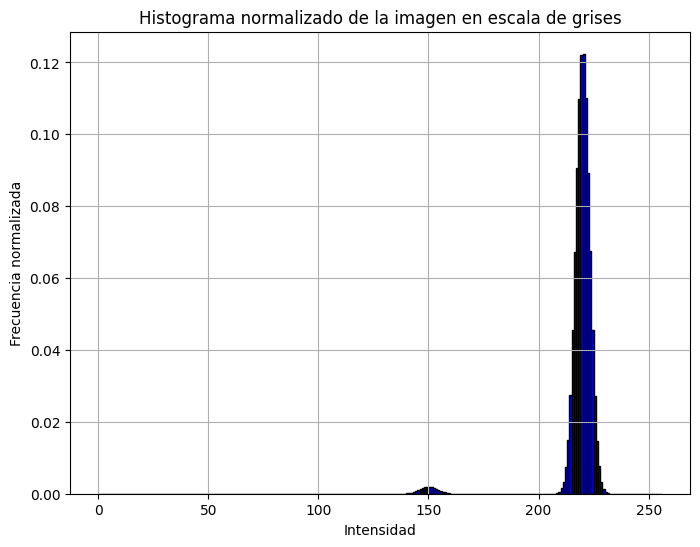

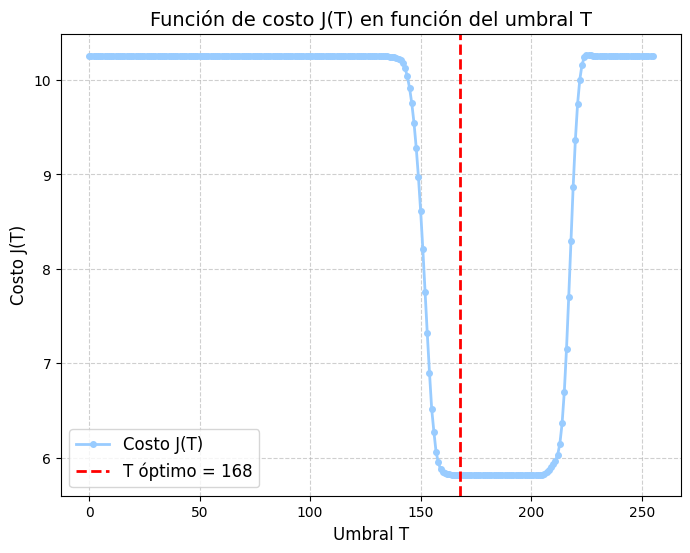

Umbral √≥ptimo œÑ: 168
Para fondo: Œº‚ÇÅ = 149.45, œÉ‚ÇÅ¬≤ = 15.37
Para objeto: Œº‚ÇÇ = 219.49, œÉ‚ÇÇ¬≤ = 10.05


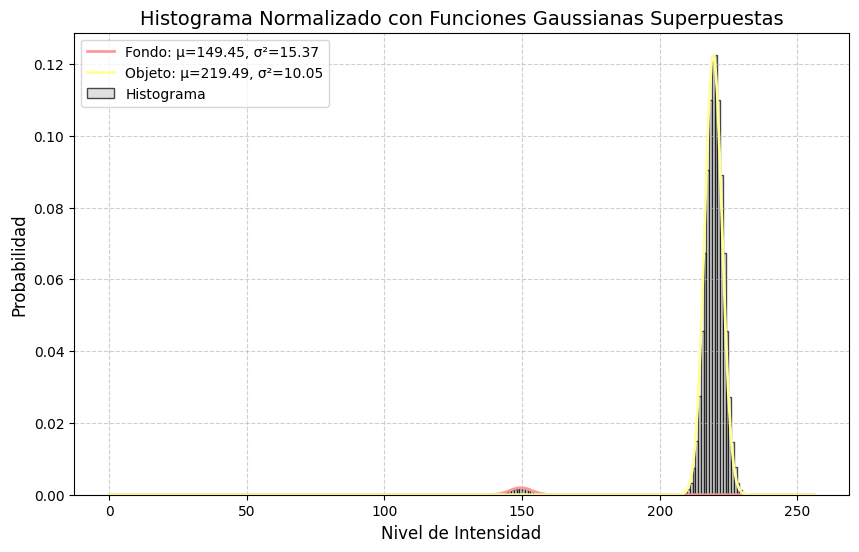

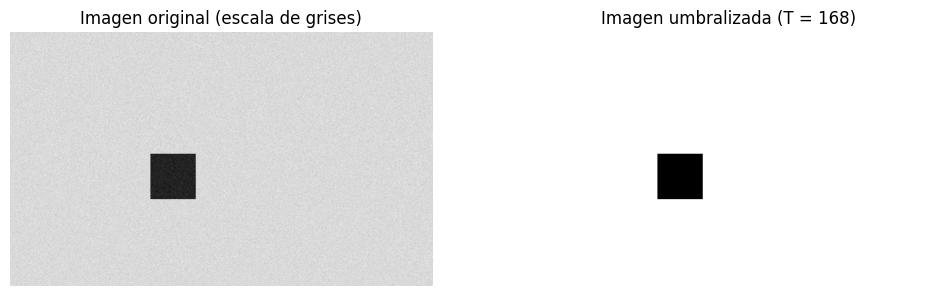

In [ ]:
T_optimo, imagen_umbralizada = calcular_T_optimo_Kittler(charge_image(cuadro1_005))

### e.

#### e.1.

Carga del Audio y An√°lisis del Histograma

En esta secci√≥n se realiza lo siguiente:
- Se carga el archivo `contaminated_audio.wav` utilizando `scipy.io.wavfile.read`.
- Si el audio es est√©reo, se convierte a mono promediando los canales.
- Se calcula la magnitud absoluta de la se√±al y se normaliza al rango [0, 255] para trabajar con una escala similar a la de im√°genes.
- Se convierte la se√±al normalizada a un tensor de PyTorch.
- Se calcula y grafica el histograma normalizado de la amplitud, lo que permite observar la distribuci√≥n de la se√±al.
  
*Nota:* Debido a que el algoritmo de Kittler fue dise√±ado para datos con distribuciones gaussianas, su aplicaci√≥n en audio (donde la se√±al de voz y silencio pueden no seguir estrictamente una distribuci√≥n normal) puede tener limitaciones. Sin embargo, este m√©todo puede proporcionar una primera aproximaci√≥n para la detecci√≥n de actividad de voz.


In [ ]:
# =============================================================================
# Funci√≥n 1: Procesamiento del Audio
# =============================================================================
def procesar_audio(audio_path: str) -> tuple:
    """
    Carga y preprocesa un archivo de audio para su an√°lisis.

    Pasos:
      1. Carga el audio usando scipy.io.wavfile.read.
      2. Si el audio es est√©reo, lo convierte a mono promediando los canales.
      3. Calcula la magnitud absoluta de la se√±al y la normaliza al rango [0, 255].
      4. Convierte la se√±al normalizada a un tensor de PyTorch.
      5. Calcula el histograma normalizado de la se√±al utilizando la funci√≥n
         calcular_histograma_normalizado.

    Par√°metros:
      audio_path : str
          Ruta del archivo de audio.

    Retorna:
      tuple: (fs, audio_tensor, hist_audio, bin_edges)
          fs           : Frecuencia de muestreo.
          audio_tensor : Tensor del audio normalizado.
          hist_audio   : Histograma normalizado de la se√±al.
          bin_edges    : Bordes de los bins usados para el histograma.
    """
    fs, audio = wavfile.read(audio_path)
    # Si el audio es est√©reo, convertirlo a mono.
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    # Calcular la magnitud y normalizar al rango [0, 255].
    audio_abs = np.abs(audio.astype(np.float32))
    audio_norm = (audio_abs / np.max(audio_abs)) * 255
    # Convertir la se√±al normalizada a tensor de PyTorch.
    audio_tensor = torch.tensor(audio_norm, dtype=torch.float32)
    # Calcular el histograma normalizado usando la funci√≥n previamente definida.
    hist_audio, bin_edges = calcular_histograma_normalizado(audio_tensor, num_bins=256)
    return fs, audio_tensor, hist_audio, bin_edges


In [ ]:
# =============================================================================
# Funci√≥n 2: Mostrar el Histograma del Audio
# =============================================================================
def mostrar_histograma_audio(hist_audio: torch.Tensor, bin_edges: np.ndarray) -> None:
    """
    Grafica el histograma normalizado de la se√±al de audio.

    Utiliza la funci√≥n graficar_histograma_normalizado para visualizar el histograma.

    Par√°metros:
      hist_audio : torch.Tensor
          Histograma normalizado del audio.
      bin_edges  : np.ndarray
          Bordes de los bins.

    Retorna:
      None. Muestra la gr√°fica.
    """
    graficar_histograma_normalizado(hist_audio, bin_edges)


#### e.2.

Gr√°fico de la Funci√≥n de Costo \( J(T) \) y Superposici√≥n de Gaussianas

En esta secci√≥n se realizan los siguientes pasos:
- Se eval√∫a la funci√≥n de costo \( J(T) \) para cada umbral candidato (T entre 0 y 254) utilizando la funci√≥n `funcion_costo_kittler` aplicada al histograma del audio.
- Se grafica \( J(T) \) y se marca el umbral √≥ptimo \( \tau \) (donde \( J(T) \) es m√≠nimo).
- Se calculan los momentos estad√≠sticos en \( \tau \) (pesos, medias y varianzas) mediante la funci√≥n `calcular_momentos_estadisticos`.
- Se superponen sobre el histograma las funciones gaussianas correspondientes a los dos grupos (por ejemplo, silencio y voz) utilizando los par√°metros obtenidos.
- Se documenta el valor \( \tau \) junto con las medias y varianzas, y se discute si estos valores son coherentes con la forma del histograma.


In [ ]:
# =============================================================================
# Funci√≥n 3: Evaluar la Funci√≥n de Costo J(T) en el Audio
# =============================================================================
def evaluar_costo_audio(hist_audio: torch.Tensor) -> tuple:
    """
    Eval√∫a la funci√≥n de costo J(T) para cada umbral T (0 a 255) a partir del histograma del audio.

    Se utiliza la funci√≥n calcular_costo_J para calcular el costo para cada T, se grafica la funci√≥n J(T)
    y se determina el umbral √≥ptimo (œÑ) que minimiza dicho costo.

    Par√°metros:
      hist_audio : torch.Tensor
          Histograma normalizado del audio.

    Retorna:
      tuple: (tau, costos)
          tau    : Umbral √≥ptimo obtenido.
          costos : Lista de costos J(T) evaluados.
    """
    costos = [calcular_costo_J(T, hist_audio) for T in range(256)]
    # Graficar la funci√≥n J(T) usando la funci√≥n ya definida.
    graficar_funcion_J(torch.tensor(costos), num_bins=256)
    costos_np = np.array(costos)
    tau = int(np.argmin(costos_np))
    return tau, costos


In [ ]:
# =============================================================================
# Funci√≥n 4: Mostrar Gaussianas Superpuestas al Histograma del Audio
# =============================================================================
def mostrar_gaussianas_audio(hist_audio: torch.Tensor, bin_edges: np.ndarray, tau: int) -> dict:
    """
    Calcula los momentos estad√≠sticos en el umbral √≥ptimo œÑ y grafica el histograma del audio
    con las funciones gaussianas superpuestas.

    Se obtienen los par√°metros (œâ, Œº y œÉ¬≤) mediante calcular_momentos_estadisticos, se crea un
    diccionario para las dos clases (silencio y voz) y se superponen las curvas gaussianas al histograma.

    Par√°metros:
      hist_audio : torch.Tensor
          Histograma normalizado del audio.
      bin_edges  : np.ndarray
          Bordes de los bins.
      tau        : int
          Umbral √≥ptimo obtenido.

    Retorna:
      dict: Los momentos estad√≠sticos calculados.
    """
    momentos = calcular_momentos_estadisticos(tau, hist_audio)
    gaussianas = [
        {"omega": momentos['omega0'], "mu": momentos['mu0'], "sigma": momentos['sigma0'], "label": "Silencio"},
        {"omega": momentos['omega1'], "mu": momentos['mu1'], "sigma": momentos['sigma1'], "label": "Voz"}
    ]
    graficar_histograma_gaussianas(hist_audio, bin_edges, gaussianas)
    print(f"Umbral √≥ptimo œÑ: {tau}")
    print(f"Silencio: Œº = {momentos['mu0']:.2f}, œÉ¬≤ = {momentos['sigma0']:.2f}")
    print(f"Voz: Œº = {momentos['mu1']:.2f}, œÉ¬≤ = {momentos['sigma1']:.2f}")
    return momentos


#### e.3.

Umbralizaci√≥n y Segmentaci√≥n del Audio

En esta secci√≥n se procede a:
- Umbralizar el audio usando el umbral √≥ptimo \( \tau \) obtenido previamente, clasificando cada muestra en "voz" (si la amplitud normalizada es mayor que \( \tau \)) o "silencio".
- Detectar los cambios de estado (de voz a silencio y viceversa) para segmentar el audio en regiones continuas.
- Se espera obtener tres segmentos: dos correspondientes a actividad de voz (segmentos de voz) y uno a falta de actividad (segmento de silencio) entre ellos.
- Se muestra la se√±al original junto con las √°reas clasificadas para una visualizaci√≥n clara de la segmentaci√≥n.


In [ ]:
# =============================================================================
# Funci√≥n 5: Segmentaci√≥n y Umbralizaci√≥n del Audio
# =============================================================================
def segmentar_audio(audio_tensor: torch.Tensor, tau: int, fs: int) -> None:
    """
    Umbraliza y segmenta la se√±al de audio usando el umbral √≥ptimo œÑ.

    Se clasifica cada muestra como "voz" (si la amplitud > œÑ) o "silencio" (si ‚â§ œÑ), se detectan los
    cambios de estado para segmentar la se√±al, se imprimen los segmentos y se grafica la se√±al con
    √°reas coloreadas que indican voz y silencio.

    Par√°metros:
      audio_tensor : torch.Tensor
          Se√±al de audio normalizada.
      tau          : int
          Umbral √≥ptimo obtenido.
      fs           : int
          Frecuencia de muestreo del audio.

    Retorna:
      None. Muestra la gr√°fica y la informaci√≥n de segmentaci√≥n.
    """
    # Umbralizar el audio: 1 para voz, 0 para silencio.
    etiquetas = (audio_tensor > tau).numpy().astype(np.uint8)
    # Detectar cambios de estado.
    cambios = np.where(np.diff(etiquetas) != 0)[0] + 1
    segmentos = []
    inicio = 0
    for cambio in cambios:
        segmentos.append((inicio, cambio))
        inicio = cambio
    segmentos.append((inicio, len(etiquetas)))

    # Clasificar segmentos.
    segmentos_voz = [seg for seg in segmentos if etiquetas[seg[0]] == 1]
    segmentos_silencio = [seg for seg in segmentos if etiquetas[seg[0]] == 0]

    print("Segmentos de voz detectados:")
    for seg in segmentos_voz:
        print(f"Inicio: {seg[0]}, Fin: {seg[1]}, Duraci√≥n: {seg[1]-seg[0]} muestras")
    print("Segmentos de silencio detectados:")
    for seg in segmentos_silencio:
        print(f"Inicio: {seg[0]}, Fin: {seg[1]}, Duraci√≥n: {seg[1]-seg[0]} muestras")

    # Visualizaci√≥n de la se√±al segmentada.
    plt.figure(figsize=(12, 4))
    tiempo = np.arange(len(audio_tensor)) / fs
    plt.plot(tiempo, audio_tensor.numpy(), color='gray', lw=0.8, label="Amplitud Normalizada")
    plt.fill_between(tiempo, 0, audio_tensor.numpy(), where=(etiquetas==1), color='red', alpha=0.4, label="Voz")
    plt.fill_between(tiempo, 0, audio_tensor.numpy(), where=(etiquetas==0), color='blue', alpha=0.3, label="Silencio")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud Normalizada")
    plt.title(f"Segmentaci√≥n del Audio usando œÑ = {tau}")
    plt.legend()
    plt.show()


In [ ]:
# =============================================================================
# Funci√≥n Principal: Procesar y Segmentar Audio
# =============================================================================
def procesar_audio_y_segmentar(audio_path: str) -> None:
    """
    Integra todo el flujo de procesamiento del audio para detectar actividad de voz.

    Pasos:
      1. Carga y preprocesa el audio.
      2. Calcula y grafica el histograma normalizado del audio.
      3. Eval√∫a la funci√≥n de costo J(T) y determina el umbral √≥ptimo œÑ.
      4. Calcula y grafica las funciones gaussianas superpuestas al histograma.
      5. Umbraliza y segmenta el audio, mostrando los segmentos de voz y silencio.

    Par√°metros:
      audio_path : str
          Ruta del archivo de audio.

    Retorna:
      None. Ejecuta todo el proceso y muestra los resultados mediante gr√°ficos e impresiones.
    """
    # Procesar el audio: carga, normalizaci√≥n y c√°lculo del histograma.
    fs, audio_tensor, hist_audio, bin_edges = procesar_audio(audio_path)

    # Graficar el histograma normalizado del audio.
    mostrar_histograma_audio(hist_audio, bin_edges)

    # Evaluar la funci√≥n de costo y obtener el umbral √≥ptimo œÑ.
    tau, _ = evaluar_costo_audio(hist_audio)

    # Calcular momentos y graficar las curvas gaussianas sobre el histograma.
    mostrar_gaussianas_audio(hist_audio, bin_edges, tau)

    # Segmentaci√≥n y umbralizaci√≥n del audio.
    segmentar_audio(audio_tensor, tau, fs)


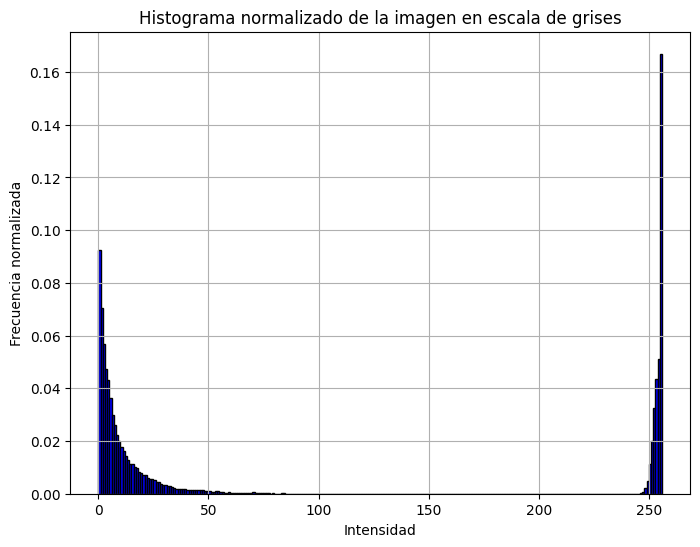

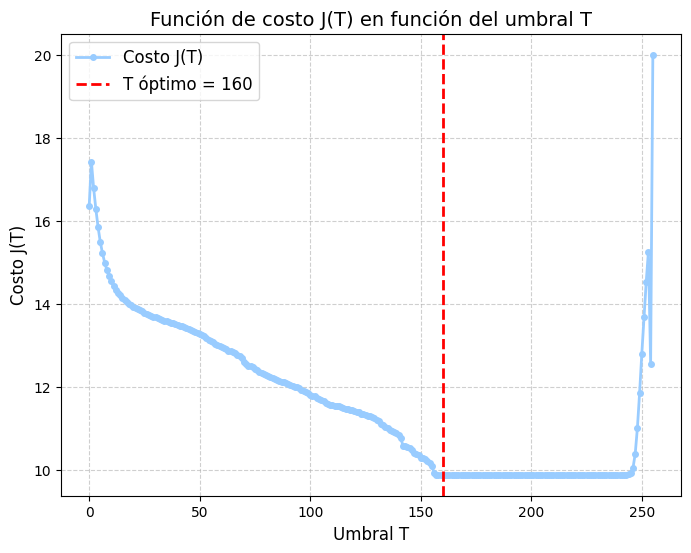

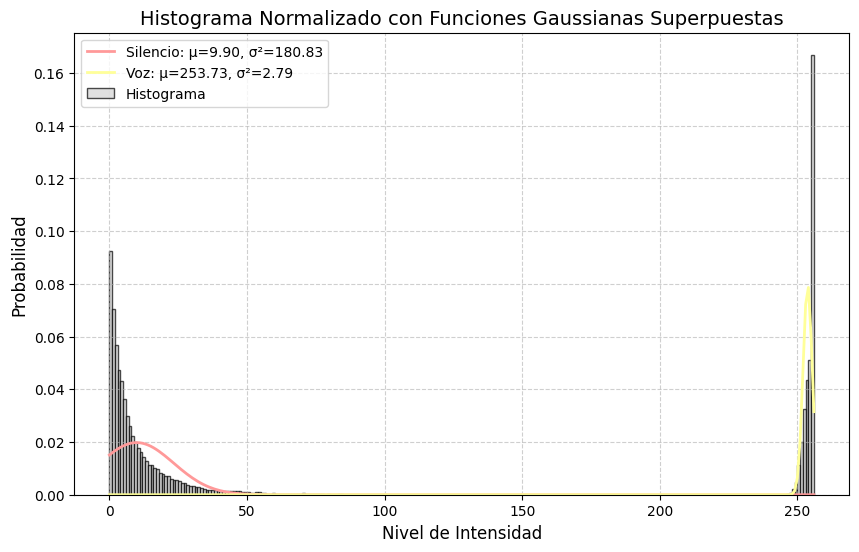

Umbral √≥ptimo œÑ: 160
Silencio: Œº = 9.90, œÉ¬≤ = 180.83
Voz: Œº = 253.73, œÉ¬≤ = 2.79
Segmentos de voz detectados:
Inicio: 84046, Fin: 168092, Duraci√≥n: 84046 muestras
Segmentos de silencio detectados:
Inicio: 0, Fin: 84046, Duraci√≥n: 84046 muestras
Inicio: 168092, Fin: 252138, Duraci√≥n: 84046 muestras


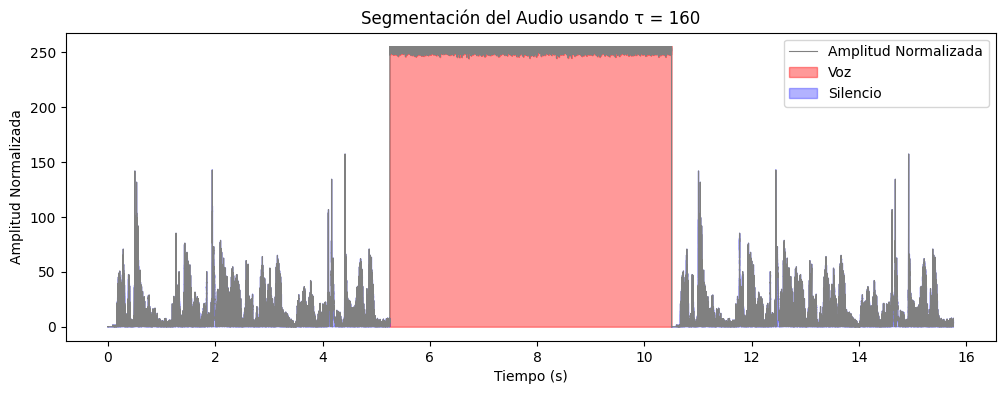

In [ ]:
# =============================================================================
# Llamada Final: Ejecuta Todo el Flujo de Procesamiento y Segmentaci√≥n de Audio
# =============================================================================
procesar_audio_y_segmentar(contaminated_audio)

### Evaluaci√≥n del algoritmo de Kittler para detecci√≥n de actividad de voz

**1) ¬øEs apropiado usar el algoritmo de Kittler para segmentar el audio?**

Al graficar el histograma del audio normalizado, se observa una distribuci√≥n claramente bimodal: una acumulaci√≥n de amplitudes muy bajas (correspondientes a silencio o ruido de fondo) y otra muy pronunciada cerca del m√°ximo (actividad de voz). Esta forma sugiere que la se√±al puede ser modelada razonablemente como una mezcla de dos distribuciones gaussianas. Por tanto, el uso del algoritmo de Kittler, que asume dicha estructura, es una aproximaci√≥n v√°lida para este caso.

---

**2) Valor √≥ptimo de \( \tau \), medias y varianzas de las gaussianas, y coherencia con el histograma**

La funci√≥n de costo \( J(T) \) fue calculada para umbrales candidatos \( T \in [0, 254] \). El valor m√≠nimo de la funci√≥n se alcanza en:

\[
\tau = 160
\]

A este umbral le corresponden los siguientes par√°metros estad√≠sticos:

- **Silencio**: \( \mu = 9.90 \), \( \sigma^2 = 180.83 \)
- **Voz**: \( \mu = 253.73 \), \( \sigma^2 = 2.79 \)

Las dos gaussianas obtenidas se superponen sobre el histograma original y muestran una buena correspondencia visual con los picos observados en los extremos de la distribuci√≥n. Esto confirma la validez del modelo estimado mediante m√°xima verosimilitud.

---

**3) Segmentaci√≥n del audio usando \( \tau \)**

Se umbraliz√≥ el audio utilizando \( \tau = 160 \), clasificando cada muestra como "voz" si su amplitud normalizada era mayor que el umbral, y "silencio" en caso contrario. Luego, se detectaron los cambios de estado para identificar segmentos contiguos. El resultado fue el siguiente:

- Segmento de **silencio**: desde 0 hasta 84046 muestras
- Segmento de **voz**: desde 84046 hasta 168092 muestras
- Segmento de **silencio**: desde 168092 hasta 252138 muestras

La visualizaci√≥n de la se√±al junto con las regiones clasificadas evidencia una segmentaci√≥n limpia en tres bloques: dos de voz y uno de silencio entre ellos, tal como se esperaba. Esto demuestra que el algoritmo de Kittler logr√≥ una segmentaci√≥n satisfactoria del audio.

---


## 2.

**Distancia de Bhattacharyya**

La **distancia de Bhattacharyya** es una medida estad√≠stica que cuantifica la similitud (o, de manera inversa, la disimilitud) entre dos funciones de densidad de probabilidad. A continuaci√≥n se detalla qu√© es, para qu√© sirve y c√≥mo se calcula.

---
**¬øQu√© es la distancia de Bhattacharyya?**

- **Definici√≥n:**  
  Es una m√©trica que eval√∫a la superposici√≥n entre dos distribuciones de probabilidad, midiendo el grado de coincidencia entre ellas.

- **Interpretaci√≥n:**  
  - Un valor **bajo** de la distancia indica que las distribuciones tienen una gran superposici√≥n, es decir, son muy similares.  
  - Un valor **alto** indica que las distribuciones est√°n m√°s separadas y tienen poca superposici√≥n.

---
**¬øPara qu√© sirve?**

- **Reconocimiento de patrones y clasificaci√≥n:**  
  Se utiliza para comparar modelos o muestras en tareas de clasificaci√≥n y reconocimiento de objetos. Por ejemplo, en visi√≥n por computadora, ayuda a evaluar qu√© tan bien se ajusta un modelo (como uno gaussiano) a los datos observados.

- **Validaci√≥n de modelos:**  
  En el contexto del algoritmo de Kittler, se usa para comparar la densidad de probabilidad estimada a partir de un modelo mixto gaussiano (p(x)) con la densidad emp√≠rica derivada del histograma de datos (q(x)). Una menor distancia indica un mejor ajuste entre el modelo y los datos reales.

- **Procesamiento de se√±ales:**  
  Se aplica en √°reas como procesamiento de se√±ales y bioinform√°tica para comparar distribuciones y validar modelos estad√≠sticos.

---
**¬øC√≥mo se calcula?**

La f√≥rmula para la distancia de Bhattacharyya es:

$$
D_B(p, q) = -\ln\left( \sum_{x \in X} \sqrt{p(x) \cdot q(x)} \right)
$$

donde:
- \( p(x) \) y \( q(x) \) son las funciones de densidad de probabilidad de las distribuciones a comparar.
- La suma se realiza sobre el dominio \( X \) de las variables.
- En la pr√°ctica, se suele incluir un peque√±o valor \( \varepsilon \) para evitar problemas con el logaritmo de cero:

$$
D_B(p, q) = -\ln\left( \sum_{x \in X} \sqrt{p(x) \cdot q(x) + \varepsilon} \right)
$$

**Pasos para calcularla:**

1. **Normalizaci√≥n:**  
   Asegurarse de que ambas distribuciones est√©n normalizadas (la suma o integral de las probabilidades debe ser 1).

2. **Producto ra√≠z:**  
   Para cada valor \( x \) en el dominio, calcular $\sqrt{p(x) \cdot q(x)}$ .

3. **Suma:**  
   Sumar todos los valores obtenidos en el paso anterior.

4. **Logaritmo negativo:**  
   Aplicar el logaritmo natural al resultado de la suma y multiplicar por -1 para obtener la distancia.

---
**Ejemplo Conceptual**

Si las dos distribuciones son muy similares, la suma $\sum_{x \in X} \sqrt{p(x) \cdot q(x)}$ ser√° cercana a 1, lo que producir√° una distancia baja. Por el contrario, si las distribuciones son muy diferentes, la suma ser√° menor y la distancia de Bhattacharyya ser√° mayor.

### a.

In [ ]:
def calcular_bhattacharyya_distance(p: np.ndarray, q: np.ndarray, epsilon: float = 1e-12) -> float:
    """
    Calcula la distancia de Bhattacharyya entre dos distribuciones de probabilidad p y q.

    La f√≥rmula utilizada es:

    $$
    D_B(p, q) = -\ln\left(\sum_{x \in X} \sqrt{p(x) \cdot q(x)}\right)
    $$

    Donde:
      - \( p(x) \) y \( q(x) \) son las funciones de densidad de probabilidad, las cuales deben estar normalizadas (la suma total es 1).
      - Se utiliza un valor peque√±o \( \varepsilon \) para evitar problemas num√©ricos en caso de que el coeficiente de Bhattacharyya sea 0.

    Pasos:
      1. Se convierten las entradas p y q a arrays de tipo float64.
      2. Se calcula el coeficiente de Bhattacharyya como la suma de la ra√≠z cuadrada del producto elemento a elemento:
         \( \text{BC} = \sum_{x \in X} \sqrt{p(x) \cdot q(x)} \).
      3. Se garantiza que el coeficiente sea al menos \( \varepsilon \) para evitar tomar el logaritmo de 0.
      4. Se calcula la distancia como el negativo del logaritmo natural del coeficiente.

    Par√°metros:
    -----------
    p : np.ndarray
        Vector que representa la densidad de probabilidad p(x), normalizado (suma 1).
    q : np.ndarray
        Vector que representa la densidad de probabilidad q(x), normalizado (suma 1).
    epsilon : float, opcional
        Valor peque√±o para evitar problemas al calcular el logaritmo de cero. Por defecto es 1e-12.

    Retorna:
    --------
    float
        La distancia de Bhattacharyya entre las distribuciones p y q.
    """
    # Asegurarse de que p y q sean arrays de NumPy de tipo float64
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)

    # Calcular el coeficiente de Bhattacharyya
    bc_coeff = np.sum(np.sqrt(p * q))

    # Evitar log(0): si el coeficiente es menor que epsilon, usar epsilon.
    bc_coeff = max(bc_coeff, epsilon)

    # Calcular la distancia como el negativo del logaritmo natural del coeficiente
    distance = -np.log(bc_coeff)
    return distance


### b.


In [ ]:
def comparar_histograma_vs_modelo_imagen(hist: torch.Tensor, moments: dict, num_bins: int = 256) -> float:
    """
    Compara el histograma real de la imagen (p(x)) con la funci√≥n de densidad estimada (q(x))
    derivada de un modelo mixto gaussiano (Kittler), y calcula la distancia de Bhattacharyya entre ellas.

    La funci√≥n realiza los siguientes pasos:
      1. Extrae los par√°metros (œâ, Œº y œÉ¬≤) de los dos grupos (fondo y objeto) del diccionario `moments`.
      2. Calcula las desviaciones est√°ndar a partir de las varianzas.
      3. Construye la funci√≥n de densidad estimada q(x) como una mezcla de dos Gaussianas:
             q(x) = œâ‚ÇÄ * N(x; Œº‚ÇÄ, œÉ‚ÇÄ) + œâ‚ÇÅ * N(x; Œº‚ÇÅ, œÉ‚ÇÅ),
         donde N(x; Œº, œÉ) es la densidad gaussiana con media Œº y desviaci√≥n est√°ndar œÉ.
      4. Normaliza q(x) para que la suma de sus valores sea 1.
      5. Calcula la distancia de Bhattacharyya entre el histograma real p(x) y q(x) utilizando la funci√≥n
         calcular_bhattacharyya_distance.
      6. Grafica ambas distribuciones para comparaci√≥n visual.

    Par√°metros:
    -----------
    hist : torch.Tensor
        Histograma normalizado de la imagen (p(x)).
    moments : dict
        Diccionario obtenido de calcular_momentos_estadisticos que contiene:
          - 'omega0', 'omega1': Pesos de fondo y objeto.
          - 'mu0', 'mu1': Medias de fondo y objeto.
          - 'sigma0', 'sigma1': Varianzas de fondo y objeto.
    num_bins : int, opcional
        N√∫mero de niveles de intensidad a evaluar (por defecto 256).

    Retorna:
    --------
    float
        La distancia de Bhattacharyya entre el histograma real p(x) y el modelo gaussiano q(x).
    """
    # Funci√≥n auxiliar para calcular la densidad gaussiana.
    def gaussian_pdf(x, mu, sigma):
        return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    # Extraer par√°metros del modelo
    omega0 = moments['omega0']
    omega1 = moments['omega1']
    mu0 = moments['mu0']
    mu1 = moments['mu1']
    varianza0 = moments['sigma0']  # Varianza del grupo fondo
    varianza1 = moments['sigma1']  # Varianza del grupo objeto

    # Calcular las desviaciones est√°ndar a partir de las varianzas.
    sigma0 = np.sqrt(varianza0)
    sigma1 = np.sqrt(varianza1)

    # Generar el eje de intensidades: de 0 a num_bins-1.
    x_range = np.linspace(0, num_bins - 1, num_bins)

    # Calcular la funci√≥n de densidad estimada q(x) como la suma de dos Gaussianas:
    q_imagen = (omega0 * gaussian_pdf(x_range, mu0, sigma0) +
                omega1 * gaussian_pdf(x_range, mu1, sigma1))

    # Normalizar q(x) para que la suma total sea 1.
    q_imagen /= (np.sum(q_imagen) + 1e-12)

    # Convertir el histograma real a array de NumPy, si es tensor.
    p_imagen = hist.numpy() if isinstance(hist, torch.Tensor) else hist

    # Calcular la distancia de Bhattacharyya utilizando la funci√≥n previamente definida.
    distancia = calcular_bhattacharyya_distance(p_imagen, q_imagen)
    print("Distancia de Bhattacharyya (Imagen):", distancia)

    # Graficar las dos distribuciones para comparaci√≥n visual.
    plt.figure(figsize=(8, 5))
    plt.bar(x_range, p_imagen, color='gray', width=1.0, alpha=0.6, label="Histograma (p)")
    plt.plot(x_range, q_imagen, color='red', lw=2, label="Modelo Gaussiano (q)")
    plt.title("Comparaci√≥n: Histograma vs. Modelo Gaussiano (Imagen)")
    plt.xlabel("Nivel de Intensidad")
    plt.ylabel("Probabilidad")
    plt.legend()
    plt.show()

    return distancia


Distancia de Bhattacharyya (Imagen): 2.403232059367945e-05


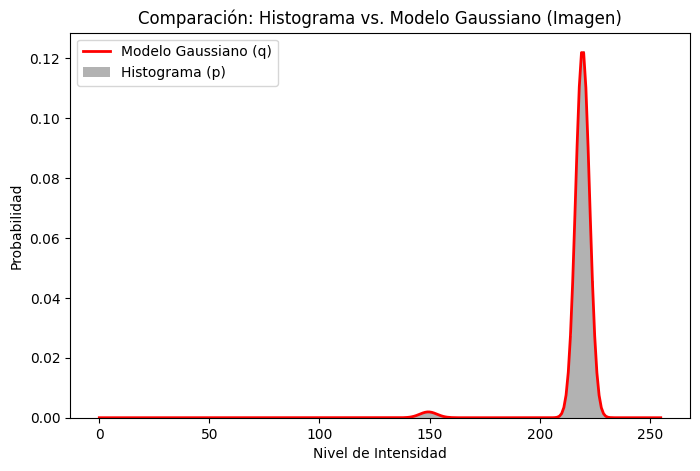

Distancia de Bhattacharyya entre el histograma y el modelo: 2.403232059367945e-05


In [ ]:
# Llamada final para el ejercicio: Comparaci√≥n de Histograma vs. Modelo Gaussiano en Imagen

# 1. Cargar la imagen
imagen_tensor = charge_image(cuadro1_005)

# 2. Calcular el histograma normalizado de la imagen y obtener los bordes de los bins.
hist, bin_edges = calcular_histograma_normalizado(imagen_tensor, num_bins=256)

# 3. Calcular la funci√≥n de costo J(T) para cada T y determinar el umbral √≥ptimo.
#    Se eval√∫a el costo para cada umbral T (0 a 255) usando la funci√≥n calcular_costo_J.
costos = [calcular_costo_J(T, hist) for T in range(256)]
costos_np = np.array(costos)
T_optimo = int(np.argmin(costos_np))

# 4. Obtener los momentos estad√≠sticos para el umbral √≥ptimo.
moments = calcular_momentos_estadisticos(T_optimo, hist)

# 5. Llamar a la funci√≥n comparar_histograma_vs_modelo_imagen para graficar la comparaci√≥n y obtener la distancia de Bhattacharyya.
distancia = comparar_histograma_vs_modelo_imagen(hist, moments, num_bins=256)
print("Distancia de Bhattacharyya entre el histograma y el modelo:", distancia)


**Comparaci√≥n en el Audio: Histograma vs. Modelo Gaussiano**

En esta secci√≥n se aplica un procedimiento similar al de la imagen, pero para el audio:
- Se utiliza el histograma normalizado del audio (previamente calculado) y los par√°metros estimados por el algoritmo de Kittler (para las dos clases: por ejemplo, silencio y voz) para construir la densidad estimada \( q(x) \) como una mezcla de dos Gaussianas.
- Se normaliza la densidad \( q(x) \) y se calcula la distancia de Bhattacharyya entre \( p(x) \) (el histograma) y \( q(x) \) (el modelo).
- Se grafica la comparaci√≥n para visualizar la aproximaci√≥n del modelo a la distribuci√≥n real del audio.

Esto permite evaluar la calidad del ajuste del modelo en el contexto del audio.

In [ ]:
def comparar_histograma_vs_modelo_audio(hist_audio: torch.Tensor, momentos: dict, num_bins: int = 256) -> float:
    """
    Compara el histograma real del audio (p(x)) con un modelo gaussiano mixto q(x) estimado a partir
    de los par√°metros obtenidos (momentos). Esta funci√≥n construye q(x) como una mezcla de dos Gaussianas
    (una para "silencio" y otra para "voz"), normaliza q(x), calcula la distancia de Bhattacharyya entre
    p(x) y q(x), y grafica ambas distribuciones para una comparaci√≥n visual.

    Pasos:
      1. Genera un vector de intensidades x_vals en el rango [0, num_bins-1].
      2. Extrae los par√°metros del diccionario `momentos`:
         - œâ‚ÇÄ y œâ‚ÇÅ: pesos (probabilidades) de cada clase.
         - Œº‚ÇÄ y Œº‚ÇÅ: medias de cada clase.
         - œÉ‚ÇÄ y œÉ‚ÇÅ: varianzas de cada clase (se calcular√° la desviaci√≥n est√°ndar como ra√≠z cuadrada).
      3. Para cada valor x en x_vals, calcula la densidad gaussiana para cada clase utilizando la funci√≥n
         auxiliar `gaussian_pdf` y suma ambas contribuciones para formar q(x).
      4. Normaliza q(x) para que su suma sea 1.
      5. Convierte el histograma real p(x) (hist_audio) a un array NumPy (si no lo es ya).
      6. Calcula la distancia de Bhattacharyya entre p(x) y q(x) mediante la funci√≥n
         `calcular_bhattacharyya_distance`.
      7. Grafica p(x) y q(x) para facilitar la comparaci√≥n visual.

    Par√°metros:
      hist_audio : torch.Tensor
          Histograma normalizado del audio, que representa la densidad p(x).
      momentos : dict
          Diccionario con los momentos estad√≠sticos del audio, con las siguientes claves:
            - 'omega0': Peso del segmento de silencio.
            - 'omega1': Peso del segmento de voz.
            - 'mu0': Media del segmento de silencio.
            - 'mu1': Media del segmento de voz.
            - 'sigma0': Varianza del segmento de silencio.
            - 'sigma1': Varianza del segmento de voz.
      num_bins : int, opcional
          N√∫mero de niveles de intensidad, por defecto 256.

    Retorna:
      float:
          La distancia de Bhattacharyya entre el histograma real p(x) y el modelo gaussiano q(x).
    """
    # Funci√≥n auxiliar para calcular la densidad gaussiana.
    def gaussian_pdf(x, mu, sigma):
        return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    # Generar el vector de intensidades: de 0 a num_bins-1.
    x_vals = np.arange(num_bins)

    # Inicializar el vector q(x) para el modelo mixto gaussiano.
    q_audio = np.zeros_like(x_vals, dtype=np.float64)

    # Extraer par√°metros de los momentos.
    omega0 = momentos['omega0']
    omega1 = momentos['omega1']
    mu0 = momentos['mu0']
    mu1 = momentos['mu1']
    # sigma0 y sigma1 son varianzas; se calcula la desviaci√≥n est√°ndar.
    sigma0 = np.sqrt(momentos['sigma0'])
    sigma1 = np.sqrt(momentos['sigma1'])

    # Construir q(x) como la suma de las dos densidades gaussianas ponderadas.
    for i, x in enumerate(x_vals):
        densidad_silencio = omega0 * gaussian_pdf(x, mu0, sigma0)
        densidad_voz = omega1 * gaussian_pdf(x, mu1, sigma1)
        q_audio[i] = densidad_silencio + densidad_voz

    # Normalizar q(x) para que la suma total sea 1.
    q_audio /= (np.sum(q_audio) + 1e-12)

    # Convertir el histograma real p(x) a un array NumPy, en caso de que sea tensor.
    p_audio = hist_audio.numpy() if isinstance(hist_audio, torch.Tensor) else hist_audio

    # Calcular la distancia de Bhattacharyya entre p(x) y q(x).
    distancia = calcular_bhattacharyya_distance(p_audio, q_audio)
    print("Distancia de Bhattacharyya (Audio):", distancia)

    # Graficar ambas distribuciones para comparaci√≥n visual.
    plt.figure(figsize=(8, 5))
    plt.bar(x_vals, p_audio, color='gray', width=1.0, alpha=0.5, label="Histograma (p)")
    plt.plot(x_vals, q_audio, color='red', lw=2, label="Modelo Gaussiano (q)")
    plt.title("Comparaci√≥n: Histograma vs. Modelo Gaussiano (Audio)")
    plt.xlabel("Nivel de Intensidad")
    plt.ylabel("Probabilidad")
    plt.legend()
    plt.show()

    return distancia


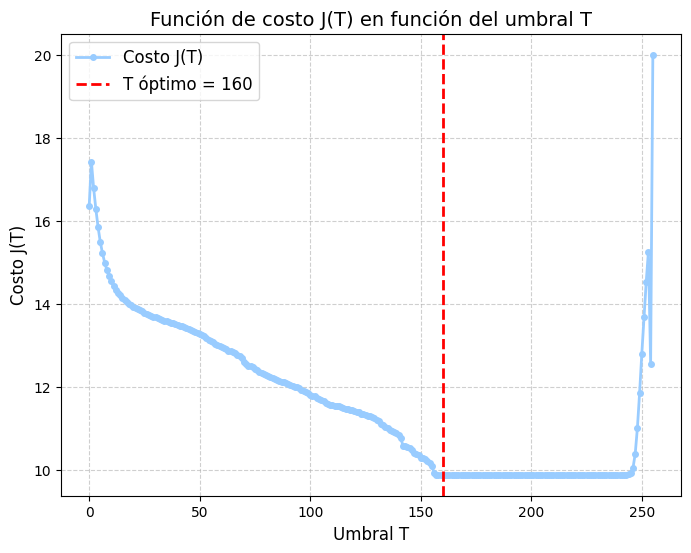

Distancia de Bhattacharyya (Audio): 0.08156438689128942


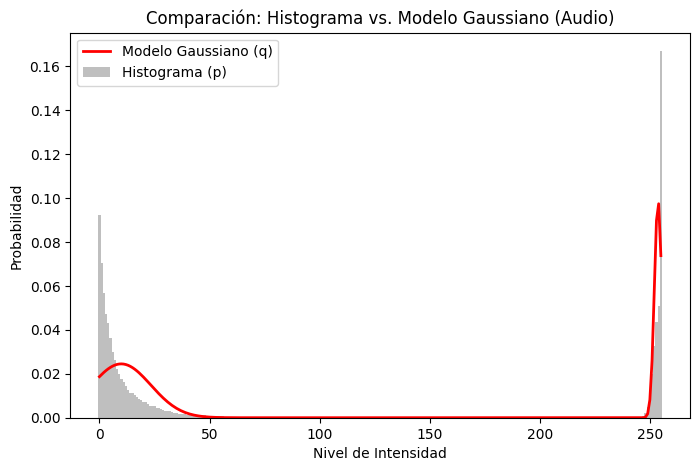

Distancia de Bhattacharyya para el audio: 0.08156438689128942


In [ ]:
# Llamada final para evaluar y comparar el modelo gaussiano vs. el histograma en el audio

# 1. Procesar el audio: cargar, normalizar y calcular el histograma normalizado.
fs, audio_tensor, hist_audio, bin_edges = procesar_audio(contaminated_audio)

# 2. Evaluar la funci√≥n de costo J(T) para obtener el umbral √≥ptimo (œÑ) a partir del histograma.
tau_audio, _ = evaluar_costo_audio(hist_audio)

# 3. Calcular los momentos estad√≠sticos (pesos, medias y varianzas) en œÑ.
moments_audio = calcular_momentos_estadisticos(tau_audio, hist_audio)

# 4. Comparar el histograma real del audio con el modelo mixto gaussiano y calcular la distancia de Bhattacharyya.
distancia_audio = comparar_histograma_vs_modelo_audio(hist_audio, moments_audio, num_bins=256)
print("Distancia de Bhattacharyya para el audio:", distancia_audio)


## 3.


### a.

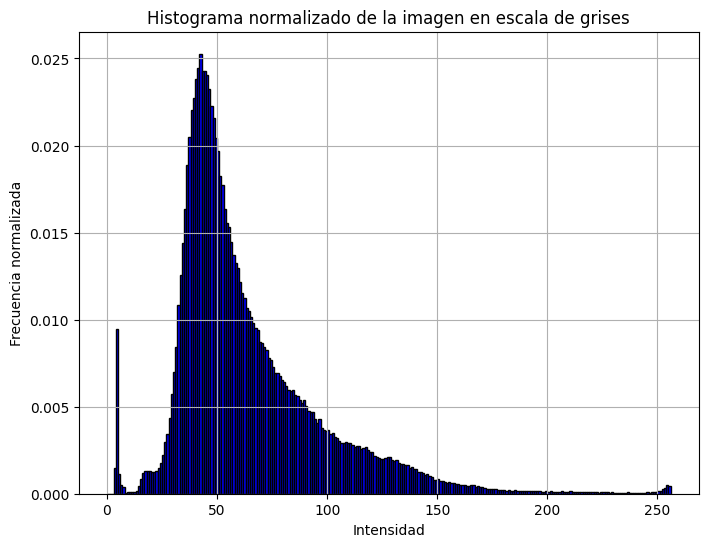

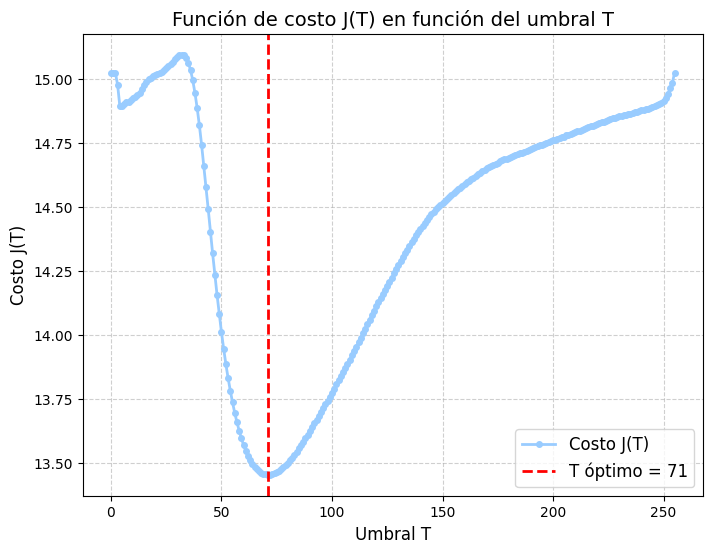

Umbral √≥ptimo œÑ: 71
Para fondo: Œº‚ÇÅ = 46.45, œÉ‚ÇÅ¬≤ = 164.58
Para objeto: Œº‚ÇÇ = 104.95, œÉ‚ÇÇ¬≤ = 1004.44


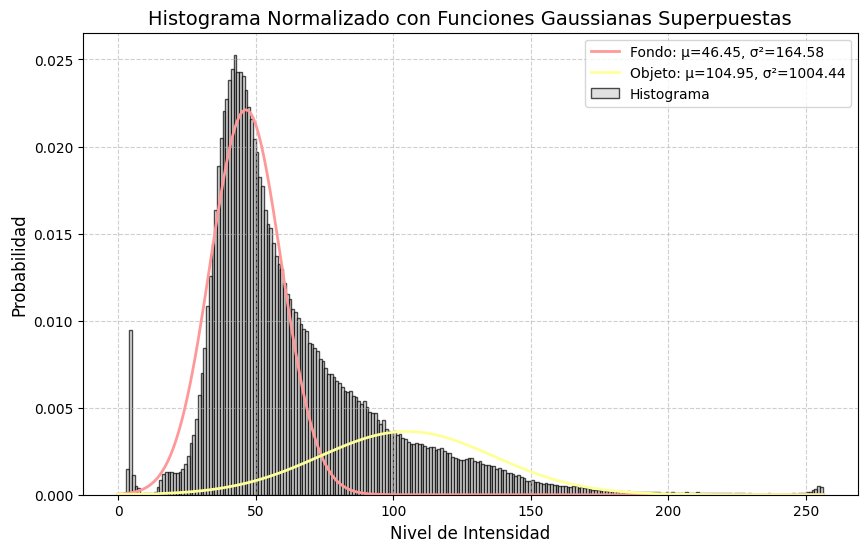

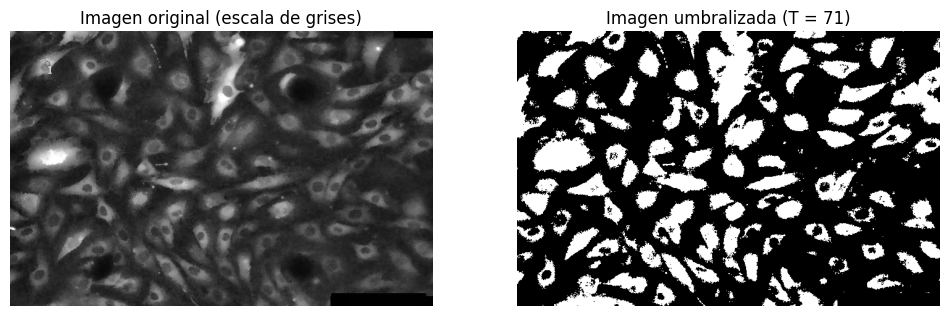

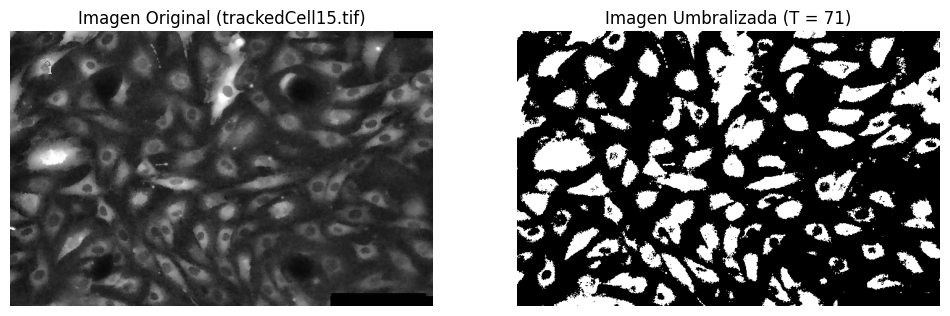

In [ ]:
# =============================================================================
# Umbralizaci√≥n de la imagen trackedCell15.tif
# =============================================================================
# Paso 1: Cargar la imagen trackedCell15.tif utilizando la funci√≥n charge_image.
imagen_tracked = charge_image(trackedCell15)

# Paso 2: Calcular el umbral √≥ptimo y la imagen umbralizada utilizando el algoritmo de Kittler.
T_optimo_tracked, imagen_umbralizada_tracked = calcular_T_optimo_Kittler(imagen_tracked)

# Paso 3: Mostrar la imagen original y la imagen umbralizada.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagen_tracked.numpy(), cmap='gray')
plt.title("Imagen Original (trackedCell15.tif)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagen_umbralizada_tracked.numpy(), cmap='gray')
plt.title(f"Imagen Umbralizada (T = {T_optimo_tracked})")
plt.axis('off')
plt.show()


**An√°lisis de Resultados - Umbralizaci√≥n de trackedCell15.tif con el Algoritmo de Kittler**

---
1. Histograma Normalizado de la Imagen

El histograma de la imagen muestra una distribuci√≥n altamente asim√©trica, con una concentraci√≥n clara de intensidades en el rango bajo (alrededor de 40-60). Esta acumulaci√≥n corresponde al fondo de la imagen (background), mientras que los valores de intensidad m√°s dispersos hacia la derecha representan las regiones m√°s brillantes, correspondientes a las c√©lulas (foreground). La presencia de dos "modas" o agrupaciones sugiere que la segmentaci√≥n binaria es razonable y viable.

---

2. Funci√≥n de Costo \( J(T) \)

La curva de la funci√≥n de costo \( J(T) \) muestra un comportamiento suave y bien definido, con un m√≠nimo marcado en \( T = 71 \). Este umbral es el valor √≥ptimo encontrado por el algoritmo de Kittler, y su ubicaci√≥n coincide con el punto de transici√≥n entre los dos grupos dominantes de intensidades en el histograma. Esta concordancia valida la solidez del criterio de minimizaci√≥n de \( J(T) \), el cual penaliza las distribuciones con alta varianza o bajo peso de clase.

---

3. Modelo Mixto Gaussiano Superpuesto

La superposici√≥n de las dos gaussianas estimadas sobre el histograma muestra una aproximaci√≥n razonable al comportamiento bimodal de los datos:

- **Fondo (clase 0):**  
  - Media: $ \mu_0 \approx 46.45 $  
  - Varianza: $ \sigma_0^2 \approx 164.58 $  
  - Se ajusta muy bien al pico dominante del histograma, modelando adecuadamente la regi√≥n oscura del fondo.

- **Objeto (clase 1):**  
  - Media: $ \mu_1 \approx 104.95 $  
  - Varianza: $ \sigma_1^2 \approx 1004.44 $
  - Captura la cola derecha del histograma, representando las zonas brillantes de las c√©lulas. La alta varianza indica una gran diversidad de intensidades dentro del objeto, lo cual es esperable en im√°genes biol√≥gicas reales con estructuras complejas e iluminaci√≥n variable.

El modelo se alinea visualmente de forma considerable con el histograma real, justificando el valor de umbral encontrado.

---

4. Imagen Umbralizada

La visualizaci√≥n de la imagen original y su correspondiente versi√≥n umbralizada revela una segmentaci√≥n medianamente efectiva de las c√©lulas:

- Las mayor√≠a de las regiones celulares se destacan claramente del fondo, generando una m√°scara binaria bien definida.
- Aunque hay cierto ruido (peque√±as manchas aisladas en fondo y objeto), la mayor parte de las c√©lulas est√°n correctamente identificadas.
- La elecci√≥n de \( T = 71 \) separa con una considerable tasa de exito las estructuras brillantes de inter√©s (n√∫cleos celulares) de la matriz de fondo oscuro.

---

5. Conclusi√≥n

El proceso completo, desde el c√°lculo del histograma hasta la estimaci√≥n del modelo gaussiano y la umbralizaci√≥n binaria‚Äî ha producido un resultado coherente, interpretable y visualmente satisfactorio. El valor √≥ptimo de umbral \( T = 71 \) logra una segmentaci√≥n eficaz, justificando el uso del algoritmo de Kittler para este tipo de im√°genes biom√©dicas.




### b.

**Posibles mejoras al algoritmo de Kittler**

Una posible mejora al algoritmo de Kittler consiste en aplicar t√©cnicas de preprocesamiento que reduzcan el ruido en la imagen antes de calcular el histograma. En particular, el uso de filtros espaciales como el filtro mediano o gaussiano puede suavizar las peque√±as fluctuaciones de intensidad debidas al ruido de adquisici√≥n, generando as√≠ una distribuci√≥n de intensidades m√°s estable y representativa. Esto impacta directamente en la calidad del histograma y, en consecuencia, en la estabilidad del c√°lculo del umbral √≥ptimo.

Adem√°s, el modelo original de Kittler asume que los datos provienen de una mezcla de dos distribuciones gaussianas, lo cual puede ser una limitaci√≥n en im√°genes reales como la de las c√©lulas, donde las intensidades del foreground suelen presentar una dispersi√≥n elevada y comportamientos multimodales. En este sentido, se propone explorar modelos de mezcla m√°s flexibles, como modelos no param√©tricos, gaussian mixture models (GMM) con m√°s de dos componentes, o incluso el uso de modelos con componentes no gaussianos como distribuciones Gamma o Rayleigh, que pueden capturar de forma m√°s realista las colas largas o asimetr√≠as presentes en los datos.

Desde el punto de vista de la optimizaci√≥n, el algoritmo podr√≠a beneficiarse de un esquema de validaci√≥n cruzada o de ajuste iterativo guiado por m√©tricas de evaluaci√≥n de segmentaci√≥n. M√©tricas como el √≠ndice de Jaccard, el coeficiente de Dice o la exactitud de clasificaci√≥n binaria frente a m√°scaras manuales (ground truth) permitir√≠an refinar el valor del umbral m√°s all√° del m√≠nimo de la funci√≥n de costo
ùêΩ
(
ùëá
)
, evaluando el desempe√±o pr√°ctico de la segmentaci√≥n en t√©rminos de solapamiento con regiones relevantes. Asimismo, se podr√≠an introducir penalizaciones adicionales en la funci√≥n de costo que tengan en cuenta la compactaci√≥n espacial o la continuidad estructural de las regiones segmentadas, lo cual ser√≠a particularmente √∫til en contextos biom√©dicos donde las estructuras de inter√©s suelen tener formas bien definidas.

En conjunto, estas mejoras apuntan a aumentar la robustez del algoritmo y su capacidad de adaptaci√≥n a distintos tipos de im√°genes, especialmente aquellas con alta complejidad estructural o ruido significativo, como es el caso en aplicaciones de microscop√≠a celular.

## 4.


Relaci√≥n entre la Distancia de Bhattacharyya y el Algoritmo de Kittler

El algoritmo de Kittler (Minimum Error Thresholding) estima un umbral √≥ptimo y los par√°metros (pesos, medias y varianzas) de dos distribuciones gaussianas que se asumen modelan las dos clases presentes en los datos (por ejemplo, fondo y objeto en im√°genes, o silencio y voz en audio).

La **distancia de Bhattacharyya** es una m√©trica que cuantifica la similitud entre dos distribuciones de probabilidad, \( p(x) \) y \( q(x) \). En este contexto:
- \( p(x) \) representa la distribuci√≥n emp√≠rica de los datos, estimada a partir del histograma.
- \( q(x) \) es el modelo mixto gaussiano ajustado a partir de los par√°metros obtenidos con Kittler.

**Interpretaci√≥n:**
- Una **distancia peque√±a** indica un gran solapamiento entre el modelo \( q(x) \) y la distribuci√≥n emp√≠rica \( p(x) \), lo que sugiere que el modelo de dos Gaussianas se ajusta bien a los datos.
- Una **distancia grande** sugiere que el modelo no captura adecuadamente la distribuci√≥n real, lo cual puede ocurrir si los datos tienen m√°s de dos modos, ruidos o si la suposici√≥n de normalidad es inadecuada.

La distancia de Bhattacharyya sirve como un indicador adicional para evaluar la calidad del ajuste del modelo estimado mediante el algoritmo de Kittler.
